### The Packages

In [1]:
# Base packages
import pandas as pd
import numpy as np
import warnings; warnings.simplefilter('ignore')
import timeit

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE  

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# Parameterization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

### The data

In [2]:
df = pd.read_csv('C:/Users/p_adu/Desktop/creditcard.csv')

Mounted at /content/drive


In [3]:
def time(sec):
    day = sec // 86400 + 1
    if day <= 1:
        return round((sec / 60 / 60),2)
    else:
        return round(((sec - (24*60*60*(day-1))) / 60 / 60),2)

df['Time'] = df.apply(lambda row: time(row['Time']), axis=1)

In [4]:
X = df.loc[:, df.columns != 'Class']
y = df.loc[:,'Class']
y = y.to_numpy().reshape(y.shape[0],1)
print(X.shape)
print(y.shape)

(284807, 30)
(284807, 1)


### Split Train and Test, Scale

In [5]:
X_train_ori, X_test_ori, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

### SCALING DATA ####
scaler = RobustScaler()
scaler.fit(X_train_ori)

X_train = scaler.transform(X_train_ori)
X_test  = scaler.transform(X_test_ori)

X_train = pd.DataFrame(X_train,columns=X.columns)
X_test  = pd.DataFrame(X_test,columns =X.columns)

print(X_train.shape)
print(X_test.shape)

(170884, 30)
(113923, 30)


#### Split test to test1/test2 for stacking

##### X_test1, y_test1 for non-smote stacking, X_test2, y_test2 for test

In [6]:
X_test1_ori, X_test2_ori, y_test1, y_test2 = train_test_split(
    X_test, y_test, test_size=0.5, random_state=1)

### SCALING DATA ####
scaler = RobustScaler()
scaler.fit(X_test1_ori)

X_test1 = scaler.transform(X_test1_ori)
X_test2 = scaler.transform(X_test2_ori)

X_test1 = pd.DataFrame(X_test1,columns=X.columns)
X_test2 = pd.DataFrame(X_test2,columns=X.columns)

### Smote

### Train Smote for estimators

##### X_train_smote, y_train_res

In [7]:
k=1 # choosing number of minority classes
method = SMOTE(k_neighbors=k, sampling_strategy='auto', random_state = 1)

X_train_res, y_train_res = method.fit_sample(X_train_ori, y_train)

print("SMOTE X_train shape: {}".format(X_train_res.shape))
print("SMOTE y_train shape: {}".format(y_train_res.shape))

### Scaling SMOTE train data as well ####
scaler = RobustScaler()
scaler.fit(X_train_res)

X_train_smote = scaler.transform(X_train_res)
X_train_smote = pd.DataFrame(X_train_smote,columns=X.columns)

print(X_train_smote.shape)

SMOTE X_train shape: (341156, 30)
SMOTE y_train shape: (341156,)
(341156, 30)


### Test1 Smote for stacking

#### X_test1_smote, y_test1_res for smote, stacking

In [8]:
k=1 # choosing number of minority classes
method = SMOTE(k_neighbors=k, sampling_strategy='auto', random_state = 1)

X_test1_res, y_test1_res = method.fit_sample(X_test1_ori, y_test1)

print("SMOTE X_train shape: {}".format(X_test1_res.shape))
print("SMOTE y_train shape: {}".format(y_test1_res.shape))

### Scaling SMOTE train data as well ####
scaler = RobustScaler()
scaler.fit(X_test1_res)

X_test1_smote = scaler.transform(X_test1_res)
X_test1_smote = pd.DataFrame(X_test1_smote,columns=X.columns)

print(X_test1_smote.shape)

SMOTE X_train shape: (113746, 30)
SMOTE y_train shape: (113746,)
(113746, 30)


### Time Function

In [9]:
import time
start_time = time.time()
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.6702880859375e-05 seconds ---


In [10]:
def timer(start_time=None):
     if not start_time:
        start_time = datetime.now()
        print(start_time)
        return start_time
     elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

### Stacking

#### Estimators

##### XGBClassifier

In [11]:
from xgboost import XGBClassifier
from numpy import nan
# RandomSearch_XGB_best_estimator= XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, gamma=0.0, gpu_id=-1,
#               importance_type='gain', interaction_constraints='',
#               learning_rate=1.0, max_delta_step=0, max_depth=1,
#               min_child_weight=1, missing=nan, monotone_constraints='()',
#               n_estimators=450, n_jobs=0, num_parallel_tree=1, random_state=0,
#               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
#               tree_method='exact', validate_parameters=1, verbosity=1)
RandomSearch_XGB_best_estimator= XGBClassifier(gamma=0.0,
              learning_rate=1.0, max_delta_step=0, max_depth=1,
              n_estimators=450, n_jobs=8, random_state=0, verbosity=1)

##### XGB Classifier, Smote

In [12]:
from xgboost import XGBClassifier
from numpy import nan
# RandomSearch_XGB_smote_best_estimator= XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, gamma=0.0, gpu_id=-1,
#               importance_type='gain', interaction_constraints='',
#               learning_rate=1.0, max_delta_step=0, max_depth=2,
#               min_child_weight=1, missing=nan, monotone_constraints='()',
#               n_estimators=450, n_jobs=0, num_parallel_tree=1, random_state=0,
#               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
#               tree_method='exact', validate_parameters=1, verbosity=None)
RandomSearch_XGB_smote_best_estimator= XGBClassifier(gamma=0.0, 
              learning_rate=1.0, max_delta_step=0, max_depth=2,
              n_estimators=450, n_jobs=8, random_state=0, verbosity=1)

##### GradientBoosting, AdaBoosting, RandomForest

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
Gra_best_estimator=GradientBoostingClassifier(max_depth=2, n_estimators=400, random_state=1)

In [14]:
from sklearn.ensemble import AdaBoostClassifier
Ada_best_estimator=AdaBoostClassifier(learning_rate=1.2, n_estimators=400, random_state=1)

In [15]:
from sklearn.ensemble import RandomForestClassifier
RFC_best_estimator=RandomForestClassifier(max_depth=6, max_features='sqrt', n_estimators=400, random_state=0)

#### Non Smote Classifiers, Non Smote Stacking

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
estimators = [
                ('Logis', LogisticRegression()),
                ('XGB', RandomSearch_XGB_best_estimator),
                ('Gra_Boost', Gra_best_estimator),
                ('Ada_Boost', Ada_best_estimator),
                ('RandomForest', RFC_best_estimator)
             ]

In [ ]:
import time
start_time = time.time()

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

ST_RF_test1=StackingClassifier(#cv=3,
                   estimators=estimators,
                   final_estimator=RandomForestClassifier(),
                   n_jobs=8, passthrough=False, stack_method='auto', verbose=10)
ST_RF_test1.fit(X_test1, y_test1)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1663.4523041248322 seconds ---


In [ ]:
ST_RF_test2_report =classification_report(y_test2,  ST_RF_test1.predict(X_test2),  output_dict=True)

In [ ]:
ST_RF_test2_report['0']['recall'], ST_RF_test2_report['1']['recall'], ST_RF_test2_report['macro avg']['recall']

(0.9998768992684299, 0.7244897959183674, 0.8621833475933987)

In [ ]:
print(classification_report(y_test2,  ST_RF_test1.predict(X_test2)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.72      0.81        98

    accuracy                           1.00     56962
   macro avg       0.95      0.86      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
import pickle
# now you can save it to a file
with open('/content/drive/MyDrive/ST_RF_test1.pkl', 'wb') as f:
    pickle.dump(ST_RF_test1, f)

#### Smote Classifiers, Smote Stacking on X_test1_smote

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
estimators_smote = [
                ('Logis', LogisticRegression()),
                ('XGB', RandomSearch_XGB_smote_best_estimator),
                ('Gra_Boost', Gra_best_estimator),
                ('Ada_Boost', Ada_best_estimator),
                ('RandomForest', RFC_best_estimator)                
             ]

In [ ]:
import time
start_time = time.time()
print(start_time)

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

ST_RF_test1_smote=StackingClassifier(#cv=3,
                   estimators=estimators_smote,
                   final_estimator=RandomForestClassifier(),
                   n_jobs=10, passthrough=False, stack_method='auto', verbose=10)
ST_RF_test1_smote.fit(X_test1_smote, y_test1_res)

print("--- %s seconds ---" % (time.time() - start_time))

1607305113.890474
--- 3809.89963054657 seconds ---


In [ ]:
ST_RF_test2_smote_report =classification_report(y_test2,  ST_RF_test1_smote.predict(X_test2),  output_dict=True)
print(ST_RF_test2_smote_report['0']['recall'], ST_RF_test2_smote_report['1']['recall'], ST_RF_test2_smote_report['macro avg']['recall'])
print(classification_report(y_test2,  ST_RF_test1_smote.predict(X_test2)))

0.9739026449071468 0.7244897959183674 0.8491962204127571
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.72      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.85      0.54     56962
weighted avg       1.00      0.97      0.98     56962



In [ ]:
import pickle
# now you can save it to a file
with open('/content/drive/MyDrive/ST_RF_test1_smote.pkl', 'wb') as f:
    pickle.dump(ST_RF_test1_smote, f)

#### Stacking Smote, CV3

In [ ]:
from datetime import datetime
now = datetime.now() # current date and time
time = now.strftime("%H:%M:%S")
print("time:", time)

time: 03:19:58


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

ST_RF_test1_smote_CV3=StackingClassifier(cv=3,
                   estimators=estimators_smote,
                   final_estimator=RandomForestClassifier(),
                   n_jobs=10, passthrough=False, stack_method='auto', verbose=2)
ST_RF_test1_smote_CV3.fit(X_test1_smote, y_test1_res)



StackingClassifier(cv=3,
                   estimators=[('Logis',
                                LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False)),
                               ('XGB',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                     

In [ ]:
#print("--- %s seconds ---" % (time.time() - start_time))

import pickle
# now you can save it to a file
with open('/content/drive/MyDrive/ST_RF_test1_smote_CV3.pkl', 'wb') as f:
    pickle.dump(ST_RF_test1_smote_CV3, f)

In [ ]:
# Evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
ST_RF_test2_smote_CV3_report =classification_report(y_test2,  ST_RF_test1_smote_CV3.predict(X_test2),  output_dict=True)
print(ST_RF_test2_smote_CV3_report['0']['recall'], ST_RF_test2_smote_CV3_report['1']['recall'], ST_RF_test2_smote_CV3_report['macro avg']['recall'])
print(classification_report(y_test2,  ST_RF_test1_smote_CV3.predict(X_test2)))

0.9818162633652223 0.6224489795918368 0.8021326214785296
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.62      0.10        98

    accuracy                           0.98     56962
   macro avg       0.53      0.80      0.55     56962
weighted avg       1.00      0.98      0.99     56962



Stacking Smote, CV3, selected Classifiers

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
estimators_smote_selected = [
                ('Logis', LogisticRegression()),
                ('XGB', RandomSearch_XGB_smote_best_estimator),
                #('Gra_Boost', Gra_best_estimator),
                ('Ada_Boost', Ada_best_estimator),
                #('RandomForest', RFC_best_estimator)                
             ]
             
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()
print(start_time)

ST_RF_test1_smote_CV3_selected=StackingClassifier(cv=3,
                   estimators=estimators_smote_selected,
                   final_estimator=RandomForestClassifier(),
                   n_jobs=10, passthrough=False, stack_method='auto', verbose=2)
ST_RF_test1_smote_CV3_selected.fit(X_test1_smote, y_test1_res)

print("--- %s seconds ---" % (time.time() - start_time))

import pickle
# now you can save it to a file
with open('/content/drive/MyDrive/ST_RF_test1_smote_CV3_selected.pkl', 'wb') as f:
    pickle.dump(ST_RF_test1_smote_CV3_selected, f)

# Evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
ST_RF_test2_smote_CV3_selected_report =classification_report(y_test2,  ST_RF_test1_smote_CV3_selected.predict(X_test2),  output_dict=True)
print(ST_RF_test2_smote_CV3_selected_report['0']['recall'], ST_RF_test2_smote_CV3_selected_report['1']['recall'], ST_RF_test2_smote_CV3_selected_report['macro avg']['recall'])
print(classification_report(y_test2,  ST_RF_test1_smote_CV3_selected.predict(X_test2)))

1607313440.7481585
--- 822.9265942573547 seconds ---
0.9727243950478335 0.7142857142857143 0.843505054666774
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.04      0.71      0.08        98

    accuracy                           0.97     56962
   macro avg       0.52      0.84      0.53     56962
weighted avg       1.00      0.97      0.98     56962



#### Logis, stacking with RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
estimators_smote_selected = [
                ('Logis', LogisticRegression())#,
                #('XGB', RandomSearch_XGB_smote_best_estimator),
                #('Gra_Boost', Gra_best_estimator),
                #('Ada_Boost', Ada_best_estimator),
                #('RandomForest', RFC_best_estimator)                
             ]
             
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()
print(start_time)

ST_RF_test1_smote_CV3_selected2=StackingClassifier(cv=5,
                   estimators=estimators_smote_selected,
                   final_estimator=RandomForestClassifier(),
                   n_jobs=10, passthrough=False, stack_method='auto', verbose=2)
ST_RF_test1_smote_CV3_selected2.fit(X_test1_smote, y_test1_res)
print("--- %s seconds ---" % (time.time() - start_time))


import pickle
# now you can save it to a file
with open('/content/drive/MyDrive/ST_RF_test1_smote_CV3_logis_randomForest.pkl', 'wb') as f:
    pickle.dump(ST_RF_test1_smote_CV3_selected2, f)


# Evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
ST_RF_test2_smote_CV3_selected2_report =classification_report(y_test2,  ST_RF_test1_smote_CV3_selected2.predict(X_test2),  output_dict=True)
print(ST_RF_test2_smote_CV3_selected2_report['0']['recall'], ST_RF_test2_smote_CV3_selected2_report['1']['recall'], ST_RF_test2_smote_CV3_selected_report['macro avg']['recall'])
print(classification_report(y_test2,  ST_RF_test1_smote_CV3_selected2.predict(X_test2)))
print(classification_report(y_test1_res,  ST_RF_test1_smote_CV3_selected2.predict(X_test1_smote)))
print("--- %s seconds ---" % (time.time() - start_time))

1607314275.1800094
--- 24.70293116569519 seconds ---
0.4788618458075408 0.9285714285714286 0.843505054666774
              precision    recall  f1-score   support

           0       1.00      0.48      0.65     56864
           1       0.00      0.93      0.01        98

    accuracy                           0.48     56962
   macro avg       0.50      0.70      0.33     56962
weighted avg       1.00      0.48      0.65     56962

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     56873
           1       0.97      0.97      0.97     56873

    accuracy                           0.97    113746
   macro avg       0.97      0.97      0.97    113746
weighted avg       0.97      0.97      0.97    113746

--- 27.476030588150024 seconds ---


In [ ]:
confusion_matrix(y_test1_res,  ST_RF_test1_smote_CV3_selected2.predict(X_test1_smote))

array([[55387,  1486],
       [ 1487, 55386]])

##### with non smote test1, bad idea

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
estimators_smote_selected = [
                ('Logis', LogisticRegression())#,
                #('XGB', RandomSearch_XGB_smote_best_estimator),
                #('Gra_Boost', Gra_best_estimator),
                #('Ada_Boost', Ada_best_estimator),
                #('RandomForest', RFC_best_estimator)                
             ]
             
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()
print(start_time)

ST_RF_test1_smote_CV3_selected2=StackingClassifier(cv=5,
                   estimators=estimators_smote_selected,
                   final_estimator=RandomForestClassifier(),
                   n_jobs=10, passthrough=False, stack_method='auto', verbose=2)
ST_RF_test1_smote_CV3_selected2.fit(X_test1, y_test1)
print("--- %s seconds ---" % (time.time() - start_time))


import pickle
# now you can save it to a file
with open('/content/drive/MyDrive/ST_RF_test1_smote_CV3_logis_randomForest.pkl', 'wb') as f:
    pickle.dump(ST_RF_test1_smote_CV3_selected2, f)


# Evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
ST_RF_test2_smote_CV3_selected2_report =classification_report(y_test2,  ST_RF_test1_smote_CV3_selected2.predict(X_test2),  output_dict=True)
print(ST_RF_test2_smote_CV3_selected2_report['0']['recall'], ST_RF_test2_smote_CV3_selected2_report['1']['recall'], ST_RF_test2_smote_CV3_selected_report['macro avg']['recall'])
print(classification_report(y_test2,  ST_RF_test1_smote_CV3_selected2.predict(X_test2)))
print(classification_report(y_test1_res,  ST_RF_test1_smote_CV3_selected2.predict(X_test1_smote)))
print("--- %s seconds ---" % (time.time() - start_time))

1607314303.5667784
--- 11.282747745513916 seconds ---
0.999490011254924 0.6326530612244898 0.843505054666774
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.68      0.63      0.66        98

    accuracy                           1.00     56962
   macro avg       0.84      0.82      0.83     56962
weighted avg       1.00      1.00      1.00     56962

              precision    recall  f1-score   support

           0       0.50      1.00      0.67     56873
           1       1.00      0.00      0.01     56873

    accuracy                           0.50    113746
   macro avg       0.75      0.50      0.34    113746
weighted avg       0.75      0.50      0.34    113746

--- 13.157107830047607 seconds ---


#### logis with adaboosting, then RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
estimators_smote_selected = [
                ('Logis', LogisticRegression()),
                #('XGB', RandomSearch_XGB_smote_best_estimator),
                #('Gra_Boost', Gra_best_estimator),
                ('Ada_Boost', Ada_best_estimator),
                #('RandomForest', RFC_best_estimator)                
             ]
             
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()
print(start_time)

ST_RF_test1_smote_CV3_selected2=StackingClassifier(cv=5,
                   estimators=estimators_smote_selected,
                   final_estimator=RandomForestClassifier(),
                   n_jobs=10, passthrough=False, stack_method='auto', verbose=2)
ST_RF_test1_smote_CV3_selected2.fit(X_test1_smote, y_test1_res)
print("--- %s seconds ---" % (time.time() - start_time))


import pickle
# now you can save it to a file
with open('/content/drive/MyDrive/ST_RF_test1_smote_CV3_logis_randomForest.pkl', 'wb') as f:
    pickle.dump(ST_RF_test1_smote_CV3_selected2, f)


# Evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
ST_RF_test2_smote_CV3_selected2_report =classification_report(y_test2,  ST_RF_test1_smote_CV3_selected2.predict(X_test2),  output_dict=True)
print(ST_RF_test2_smote_CV3_selected2_report['0']['recall'], ST_RF_test2_smote_CV3_selected2_report['1']['recall'], ST_RF_test2_smote_CV3_selected_report['macro avg']['recall'])
print(classification_report(y_test2,  ST_RF_test1_smote_CV3_selected2.predict(X_test2)))
print(classification_report(y_test1_res,  ST_RF_test1_smote_CV3_selected2.predict(X_test1_smote)))
print("--- %s seconds ---" % (time.time() - start_time))

1607314316.7467165
--- 1109.7515614032745 seconds ---
0.9564399268429938 0.673469387755102 0.843505054666774
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.03      0.67      0.05        98

    accuracy                           0.96     56962
   macro avg       0.51      0.81      0.51     56962
weighted avg       1.00      0.96      0.98     56962

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56873
           1       1.00      1.00      1.00     56873

    accuracy                           1.00    113746
   macro avg       1.00      1.00      1.00    113746
weighted avg       1.00      1.00      1.00    113746

--- 1130.1536211967468 seconds ---


#### Logis then logis

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
estimators_smote_selected = [
                ('Logis', LogisticRegression())#,
                #('XGB', RandomSearch_XGB_smote_best_estimator),
                #('Gra_Boost', Gra_best_estimator),
                #('Ada_Boost', Ada_best_estimator),
                #('RandomForest', RFC_best_estimator)                
             ]
             
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()
print(start_time)

ST_RF_test1_smote_CV3_selected2=StackingClassifier(cv=5,
                   estimators=estimators_smote_selected,
                   final_estimator=LogisticRegression(),
                   n_jobs=10, passthrough=False, stack_method='auto', verbose=2)
ST_RF_test1_smote_CV3_selected2.fit(X_test1_smote, y_test1_res)
print("--- %s seconds ---" % (time.time() - start_time))


import pickle
# now you can save it to a file
with open('/content/drive/MyDrive/ST_RF_test1_smote_CV3_logis_randomForest.pkl', 'wb') as f:
    pickle.dump(ST_RF_test1_smote_CV3_selected2, f)


# Evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
ST_RF_test2_smote_CV3_selected2_report =classification_report(y_test2,  ST_RF_test1_smote_CV3_selected2.predict(X_test2),  output_dict=True)
print(ST_RF_test2_smote_CV3_selected2_report['0']['recall'], ST_RF_test2_smote_CV3_selected2_report['1']['recall'], ST_RF_test2_smote_CV3_selected_report['macro avg']['recall'])
print(classification_report(y_test2,  ST_RF_test1_smote_CV3_selected2.predict(X_test2)))
print(classification_report(y_test1_res,  ST_RF_test1_smote_CV3_selected2.predict(X_test1_smote)))
print("--- %s seconds ---" % (time.time() - start_time))

1607315446.927092
--- 17.390547275543213 seconds ---
0.4594822734946539 0.9387755102040817 0.843505054666774
              precision    recall  f1-score   support

           0       1.00      0.46      0.63     56864
           1       0.00      0.94      0.01        98

    accuracy                           0.46     56962
   macro avg       0.50      0.70      0.32     56962
weighted avg       1.00      0.46      0.63     56962

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     56873
           1       0.98      0.98      0.98     56873

    accuracy                           0.98    113746
   macro avg       0.98      0.98      0.98    113746
weighted avg       0.98      0.98      0.98    113746

--- 17.903704166412354 seconds ---


#### RandomForest then Logis

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
estimators_smote_selected = [
                #('Logis', LogisticRegression())#,
                #('XGB', RandomSearch_XGB_smote_best_estimator),
                #('Gra_Boost', Gra_best_estimator),
                #('Ada_Boost', Ada_best_estimator),
                ('RandomForest', RFC_best_estimator)                
             ]
             
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()
print(start_time)

ST_RF_test1_smote_CV3_selected2=StackingClassifier(cv=5,
                   estimators=estimators_smote_selected,
                   final_estimator=LogisticRegression(),
                   n_jobs=10, passthrough=False, stack_method='auto', verbose=2)
ST_RF_test1_smote_CV3_selected2.fit(X_test1_smote, y_test1_res)
print("--- %s seconds ---" % (time.time() - start_time))


import pickle
# now you can save it to a file
with open('/content/drive/MyDrive/ST_RF_test1_smote_CV3_logis_randomForest.pkl', 'wb') as f:
    pickle.dump(ST_RF_test1_smote_CV3_selected2, f)


# Evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
ST_RF_test2_smote_CV3_selected2_report =classification_report(y_test2,  ST_RF_test1_smote_CV3_selected2.predict(X_test2),  output_dict=True)
print(ST_RF_test2_smote_CV3_selected2_report['0']['recall'], ST_RF_test2_smote_CV3_selected2_report['1']['recall'], ST_RF_test2_smote_CV3_selected_report['macro avg']['recall'])
print('Test2')
print(classification_report(y_test2,  ST_RF_test1_smote_CV3_selected2.predict(X_test2)))
print('Test1')
print(classification_report(y_test1_res,  ST_RF_test1_smote_CV3_selected2.predict(X_test1_smote)))
print("--- %s seconds ---" % (time.time() - start_time))

1607318622.533145
--- 605.7108948230743 seconds ---
0.9197910804727069 0.8979591836734694 0.843505054666774
Test2
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     56864
           1       0.02      0.90      0.04        98

    accuracy                           0.92     56962
   macro avg       0.51      0.91      0.50     56962
weighted avg       1.00      0.92      0.96     56962

Test1
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     56873
           1       1.00      0.99      1.00     56873

    accuracy                           1.00    113746
   macro avg       1.00      1.00      1.00    113746
weighted avg       1.00      1.00      1.00    113746

--- 612.7324695587158 seconds ---


In [ ]:
cla_random_logis=classification_report(y_test1_res,  ST_RF_test1_smote_CV3_selected2.predict(X_test1_smote), output_dict=True)
cla_random_logis['0']['recall'], cla_random_logis['1']['recall'], cla_random_logis['weighted avg']['recall']

(0.9967471383609094, 0.9944261776238286, 0.995586657992369)

In [ ]:
cla_random_logis=classification_report(y_test2,  ST_RF_test1_smote_CV3_selected2.predict(X_test2), output_dict=True)
cla_random_logis['0']['recall'], cla_random_logis['1']['recall'], cla_random_logis['weighted avg']['recall']

(0.9197910804727069, 0.8979591836734694, 0.9197535198904533)

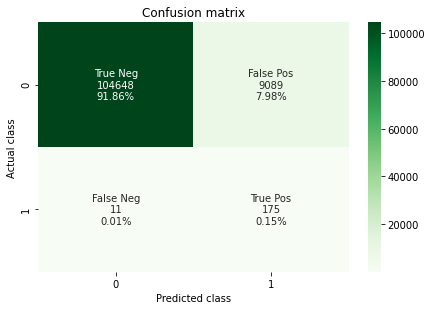

In [ ]:
# Create Confusion Matrix
optimizedAdaMatrix = confusion_matrix(y_test,ST_RF_test1_smote_CV3_selected2.predict(X_test))

# Create label names
group_names = ['True Neg','False Pos','False Neg','True Pos']

# Extract counts from basic matrix arrays
group_counts = ["{0:0.0f}".format(value) for value in
                optimizedAdaMatrix.flatten()]

# Calculate percentages
group_percentages = ["{0:.2%}".format(value) for value in
                     optimizedAdaMatrix.flatten()/np.sum(optimizedAdaMatrix)]

# Create actual labels by zipping together previous lists
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Create heatmap
sns.heatmap(optimizedAdaMatrix, annot=labels, fmt='', cmap='Greens')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
pass

#### Full dataset, RandomFor then logis

In [ ]:
scaler = RobustScaler()
scaler.fit(X_train_ori)

X_full = scaler.transform(X)
X_full = pd.DataFrame(X_full,columns=X.columns)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
estimators_smote_selected = [
                #('Logis', LogisticRegression())#,
                #('XGB', RandomSearch_XGB_smote_best_estimator),
                #('Gra_Boost', Gra_best_estimator),
                #('Ada_Boost', Ada_best_estimator),
                ('RandomForest', RFC_best_estimator)                
             ]
             
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()
print(start_time)

ST_RF_test1_smote_CV3_selected2=StackingClassifier(cv=3,
                   estimators=estimators_smote_selected,
                   final_estimator=LogisticRegression(),
                   n_jobs=10, passthrough=False, stack_method='auto', verbose=2)
ST_RF_test1_smote_CV3_selected2.fit(X_test1_smote, y_test1_res)
print("--- %s seconds ---" % (time.time() - start_time))


# Evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
ST_RF_test2_smote_CV3_selected2_report =classification_report(y_test2,  ST_RF_test1_smote_CV3_selected2.predict(X_test2),  output_dict=True)
print(ST_RF_test2_smote_CV3_selected2_report['0']['recall'], ST_RF_test2_smote_CV3_selected2_report['1']['recall'], ST_RF_test2_smote_CV3_selected2_report['macro avg']['recall'])


print('full dataset')
print(classification_report(y,  ST_RF_test1_smote_CV3_selected2.predict(X_full)))
print("--- %s seconds ---" % (time.time() - start_time))

print('Test2')
print(classification_report(y_test2,  ST_RF_test1_smote_CV3_selected2.predict(X_test2)))
print('Test1')
print(classification_report(y_test1_res,  ST_RF_test1_smote_CV3_selected2.predict(X_test1_smote)))
print("--- %s seconds ---" % (time.time() - start_time))

1607302348.136732
--- 365.07473278045654 seconds ---
0.9197559088351154 0.8979591836734694 0.9088575462542924
full dataset
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    284315
           1       0.02      0.93      0.04       492

    accuracy                           0.92    284807
   macro avg       0.51      0.92      0.50    284807
weighted avg       1.00      0.92      0.96    284807

--- 375.7167525291443 seconds ---
Test2
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     56864
           1       0.02      0.90      0.04        98

    accuracy                           0.92     56962
   macro avg       0.51      0.91      0.50     56962
weighted avg       1.00      0.92      0.96     56962

Test1
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     56873
           1       1.00      0.99      1.00     56873

    accuracy 

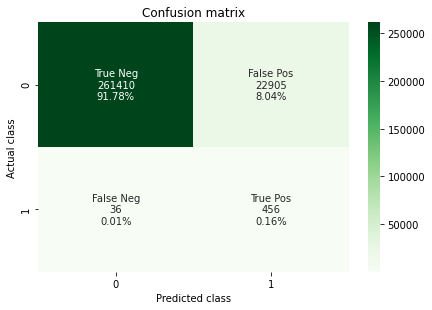

In [ ]:
# Create Confusion Matrix
optimizedAdaMatrix = confusion_matrix(y,ST_RF_test1_smote_CV3_selected2.predict(X_full))

# Create label names
group_names = ['True Neg','False Pos','False Neg','True Pos']

# Extract counts from basic matrix arrays
group_counts = ["{0:0.0f}".format(value) for value in
                optimizedAdaMatrix.flatten()]

# Calculate percentages
group_percentages = ["{0:.2%}".format(value) for value in
                     optimizedAdaMatrix.flatten()/np.sum(optimizedAdaMatrix)]

# Create actual labels by zipping together previous lists
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Create heatmap
sns.heatmap(optimizedAdaMatrix, annot=labels, fmt='', cmap='Greens')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
pass

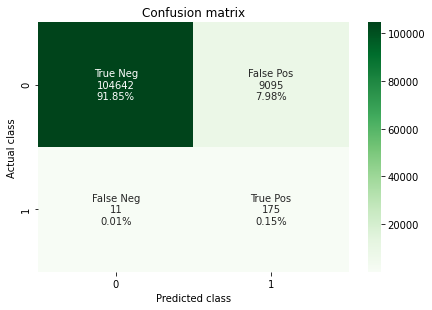

In [ ]:
# Create Confusion Matrix
optimizedAdaMatrix = confusion_matrix(y_test,ST_RF_test1_smote_CV3_selected2.predict(X_test))

# Create label names
group_names = ['True Neg','False Pos','False Neg','True Pos']

# Extract counts from basic matrix arrays
group_counts = ["{0:0.0f}".format(value) for value in
                optimizedAdaMatrix.flatten()]

# Calculate percentages
group_percentages = ["{0:.2%}".format(value) for value in
                     optimizedAdaMatrix.flatten()/np.sum(optimizedAdaMatrix)]

# Create actual labels by zipping together previous lists
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Create heatmap
sns.heatmap(optimizedAdaMatrix, annot=labels, fmt='', cmap='Greens')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
pass

#### RondomForest, Logis, nonSmote

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
estimators_smote_selected = [
                #('Logis', LogisticRegression())#,
                #('XGB', RandomSearch_XGB_smote_best_estimator),
                #('Gra_Boost', Gra_best_estimator),
                #('Ada_Boost', Ada_best_estimator),
                ('RandomForest', RFC_best_estimator)                
             ]
             
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()
print(start_time)

ST_RF_test1_smote_CV3_selected2=StackingClassifier(cv=5,
                   estimators=estimators_smote_selected,
                   final_estimator=LogisticRegression(),
                   n_jobs=10, passthrough=False, stack_method='auto', verbose=2)
ST_RF_test1_smote_CV3_selected2.fit(X_test1, y_test1)
print("--- %s seconds ---" % (time.time() - start_time))

# Evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
ST_RF_test2_smote_CV3_selected2_report =classification_report(y_test2,  ST_RF_test1_smote_CV3_selected2.predict(X_test2),  output_dict=True)
print(ST_RF_test2_smote_CV3_selected2_report['0']['recall'], ST_RF_test2_smote_CV3_selected2_report['1']['recall'], ST_RF_test2_smote_CV3_selected2_report['macro avg']['recall'])
print('Test2')
print(classification_report(y_test2,  ST_RF_test1_smote_CV3_selected2.predict(X_test2)))
print('Test1')
print(classification_report(y_test1,  ST_RF_test1_smote_CV3_selected2.predict(X_test1)))
print("--- %s seconds ---" % (time.time() - start_time))


1607319244.8647413
--- 292.03237080574036 seconds ---
0.9998768992684299 0.5306122448979592 0.7652445720831946
Test2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.53      0.66        98

    accuracy                           1.00     56962
   macro avg       0.94      0.77      0.83     56962
weighted avg       1.00      1.00      1.00     56962

Test1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56873
           1       1.00      0.82      0.90        88

    accuracy                           1.00     56961
   macro avg       1.00      0.91      0.95     56961
weighted avg       1.00      1.00      1.00     56961

--- 296.0210905075073 seconds ---


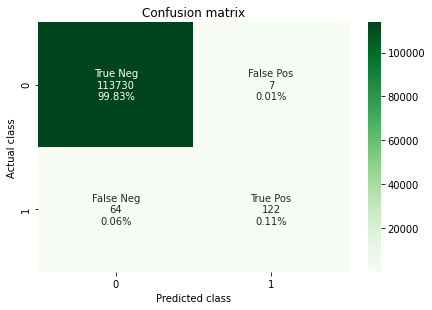

In [ ]:
# Create Confusion Matrix
optimizedAdaMatrix = confusion_matrix(y_test,ST_RF_test1_smote_CV3_selected2.predict(X_test))

# Create label names
group_names = ['True Neg','False Pos','False Neg','True Pos']

# Extract counts from basic matrix arrays
group_counts = ["{0:0.0f}".format(value) for value in
                optimizedAdaMatrix.flatten()]

# Calculate percentages
group_percentages = ["{0:.2%}".format(value) for value in
                     optimizedAdaMatrix.flatten()/np.sum(optimizedAdaMatrix)]

# Create actual labels by zipping together previous lists
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Create heatmap
sns.heatmap(optimizedAdaMatrix, annot=labels, fmt='', cmap='Greens')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
pass

#### RandomForest, AdaBoosting, then Logis

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
estimators_smote_selected = [
                #('Logis', LogisticRegression())#,
                #('XGB', RandomSearch_XGB_smote_best_estimator),
                #('Gra_Boost', Gra_best_estimator),
                ('Ada_Boost', Ada_best_estimator),
                ('RandomForest', RFC_best_estimator)                
             ]
             
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()
print(start_time)

ST_RF_test1_smote_CV3_selected3=StackingClassifier(cv=5,
                   estimators=estimators_smote_selected,
                   final_estimator=LogisticRegression(),
                   n_jobs=10, passthrough=False, stack_method='auto', verbose=2)
ST_RF_test1_smote_CV3_selected3.fit(X_test1_smote, y_test1_res)
print("--- %s seconds ---" % (time.time() - start_time))

# Evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
ST_RF_test2_smote_CV3_selected3_report =classification_report(y_test2,  ST_RF_test1_smote_CV3_selected3.predict(X_test2),  output_dict=True)
print(ST_RF_test2_smote_CV3_selected3_report['0']['recall'], ST_RF_test2_smote_CV3_selected3_report['1']['recall'], ST_RF_test2_smote_CV3_selected3_report['macro avg']['recall'])
print(classification_report(y_test2,  ST_RF_test1_smote_CV3_selected3.predict(X_test2)))
print(classification_report(y_test1_res,  ST_RF_test1_smote_CV3_selected3.predict(X_test1_smote)))
print("--- %s seconds ---" % (time.time() - start_time))
cla_random_ada_logis=classification_report(y_test1_res,  ST_RF_test1_smote_CV3_selected3.predict(X_test1_smote), output_dict=True)
cla_random_ada_logis['0']['recall'], cla_random_ada_logis['1']['recall'], cla_random_ada_logis['weighted avg']['recall']


1607319543.7404757
--- 1665.9841434955597 seconds ---
0.9220596510973551 0.8877551020408163 0.9049073765690857
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     56864
           1       0.02      0.89      0.04        98

    accuracy                           0.92     56962
   macro avg       0.51      0.90      0.50     56962
weighted avg       1.00      0.92      0.96     56962

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     56873
           1       1.00      0.99      1.00     56873

    accuracy                           1.00    113746
   macro avg       1.00      1.00      1.00    113746
weighted avg       1.00      1.00      1.00    113746

--- 1692.5953161716461 seconds ---


(0.997063633006875, 0.9947075061980202, 0.9958855696024476)

#### Training on non-smote Test1

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
estimators_smote_selected = [
                #('Logis', LogisticRegression())#,
                #('XGB', RandomSearch_XGB_smote_best_estimator),
                #('Gra_Boost', Gra_best_estimator),
                ('Ada_Boost', Ada_best_estimator),
                ('RandomForest', RFC_best_estimator)                
             ]
             
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()
print(start_time)

ST_RF_test1_smote_CV3_selected3=StackingClassifier(cv=5,
                   estimators=estimators_smote_selected,
                   final_estimator=LogisticRegression(),
                   n_jobs=10, passthrough=False, stack_method='auto', verbose=2)
ST_RF_test1_smote_CV3_selected3.fit(X_test1, y_test1)
print("--- %s seconds ---" % (time.time() - start_time))

# Evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
ST_RF_test2_smote_CV3_selected3_report =classification_report(y_test2,  ST_RF_test1_smote_CV3_selected3.predict(X_test2),  output_dict=True)
print(ST_RF_test2_smote_CV3_selected3_report['0']['recall'], ST_RF_test2_smote_CV3_selected3_report['1']['recall'], ST_RF_test2_smote_CV3_selected3_report['macro avg']['recall'])
print(classification_report(y_test2,  ST_RF_test1_smote_CV3_selected3.predict(X_test2)))
print(classification_report(y_test1,  ST_RF_test1_smote_CV3_selected3.predict(X_test1)))
print("--- %s seconds ---" % (time.time() - start_time))
cla_random_ada_logis=classification_report(y_test1,  ST_RF_test1_smote_CV3_selected3.predict(X_test1), output_dict=True)
cla_random_ada_logis['0']['recall'], cla_random_ada_logis['1']['recall'], cla_random_ada_logis['weighted avg']['recall']

1607321249.4323354
--- 758.5185372829437 seconds ---
0.9998768992684299 0.5306122448979592 0.7652445720831946
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.53      0.66        98

    accuracy                           1.00     56962
   macro avg       0.94      0.77      0.83     56962
weighted avg       1.00      1.00      1.00     56962

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56873
           1       1.00      0.82      0.90        88

    accuracy                           1.00     56961
   macro avg       1.00      0.91      0.95     56961
weighted avg       1.00      1.00      1.00     56961

--- 776.9966769218445 seconds ---


(1.0, 0.8181818181818182, 0.9997191060550201)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
estimators_smote_selected = [
                #('Logis', LogisticRegression())#,
                ('XGB', RandomSearch_XGB_smote_best_estimator),
                #('Gra_Boost', Gra_best_estimator),
                #('Ada_Boost', Ada_best_estimator),
                ('RandomForest', RFC_best_estimator)                
             ]
             
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()
print(start_time)

ST_RF_test1_smote_CV3_selected3=StackingClassifier(cv=5,
                   estimators=estimators_smote_selected,
                   final_estimator=LogisticRegression(),
                   n_jobs=10, passthrough=False, stack_method='auto', verbose=2)
ST_RF_test1_smote_CV3_selected3.fit(X_test1, y_test1)
print("--- %s seconds ---" % (time.time() - start_time))


1607322032.4957905
--- 381.4798412322998 seconds ---


0.9998593134496342 0.6326530612244898 0.816256187337062
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.63      0.74        98

    accuracy                           1.00     56962
   macro avg       0.94      0.82      0.87     56962
weighted avg       1.00      1.00      1.00     56962

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56873
           1       1.00      0.85      0.92        88

    accuracy                           1.00     56961
   macro avg       1.00      0.93      0.96     56961
weighted avg       1.00      1.00      1.00     56961

--- 386.452486038208 seconds ---


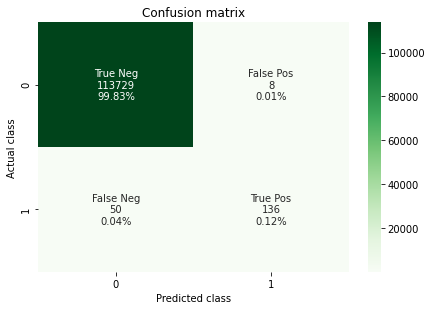

In [ ]:

# Evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
ST_RF_test2_smote_CV3_selected3_report =classification_report(y_test2,  ST_RF_test1_smote_CV3_selected3.predict(X_test2),  output_dict=True)
print(ST_RF_test2_smote_CV3_selected3_report['0']['recall'], ST_RF_test2_smote_CV3_selected3_report['1']['recall'], ST_RF_test2_smote_CV3_selected3_report['macro avg']['recall'])
print(classification_report(y_test2,  ST_RF_test1_smote_CV3_selected3.predict(X_test2)))
print(classification_report(y_test1,  ST_RF_test1_smote_CV3_selected3.predict(X_test1)))
print("--- %s seconds ---" % (time.time() - start_time))

cla_random_ada_logis=classification_report(y_test1,  ST_RF_test1_smote_CV3_selected3.predict(X_test1), output_dict=True)
cla_random_ada_logis['0']['recall'], cla_random_ada_logis['1']['recall'], cla_random_ada_logis['weighted avg']['recall']

# Create Confusion Matrix
optimizedAdaMatrix = confusion_matrix(y_test,ST_RF_test1_smote_CV3_selected3.predict(X_test))

# Create label names
group_names = ['True Neg','False Pos','False Neg','True Pos']

# Extract counts from basic matrix arrays
group_counts = ["{0:0.0f}".format(value) for value in
                optimizedAdaMatrix.flatten()]

# Calculate percentages
group_percentages = ["{0:.2%}".format(value) for value in
                     optimizedAdaMatrix.flatten()/np.sum(optimizedAdaMatrix)]

# Create actual labels by zipping together previous lists
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Create heatmap
sns.heatmap(optimizedAdaMatrix, annot=labels, fmt='', cmap='Greens')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
pass

1607322424.4583871
--- 297.244277715683 seconds ---
0.9998065559932471 0.673469387755102 0.8366379718741745
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.67      0.75        98

    accuracy                           1.00     56962
   macro avg       0.93      0.84      0.88     56962
weighted avg       1.00      1.00      1.00     56962

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56873
           1       1.00      0.83      0.91        88

    accuracy                           1.00     56961
   macro avg       1.00      0.91      0.95     56961
weighted avg       1.00      1.00      1.00     56961

--- 301.38729453086853 seconds ---


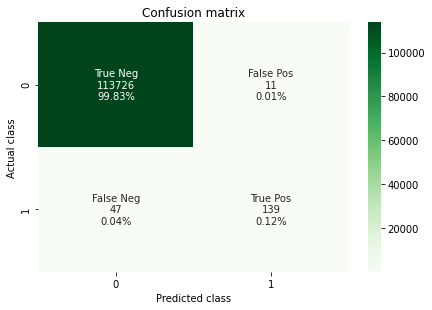

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
estimators_smote_selected = [
                #('Logis', LogisticRegression())#,
                #('XGB', RandomSearch_XGB_smote_best_estimator),
                #('Gra_Boost', Gra_best_estimator),
                #('Ada_Boost', Ada_best_estimator),
                ('RandomForest', RFC_best_estimator)                
             ]
             
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()
print(start_time)

ST_RF_test1_smote_CV3_selected3=StackingClassifier(cv=5,
                   estimators=estimators_smote_selected,
                   final_estimator=XGBClassifier(),
                   n_jobs=10, passthrough=False, stack_method='auto', verbose=2)
ST_RF_test1_smote_CV3_selected3.fit(X_test1, y_test1)
print("--- %s seconds ---" % (time.time() - start_time))


# Evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
ST_RF_test2_smote_CV3_selected3_report =classification_report(y_test2,  ST_RF_test1_smote_CV3_selected3.predict(X_test2),  output_dict=True)
print(ST_RF_test2_smote_CV3_selected3_report['0']['recall'], ST_RF_test2_smote_CV3_selected3_report['1']['recall'], ST_RF_test2_smote_CV3_selected3_report['macro avg']['recall'])
print(classification_report(y_test2,  ST_RF_test1_smote_CV3_selected3.predict(X_test2)))
print(classification_report(y_test1,  ST_RF_test1_smote_CV3_selected3.predict(X_test1)))
print("--- %s seconds ---" % (time.time() - start_time))

cla_random_ada_logis=classification_report(y_test1,  ST_RF_test1_smote_CV3_selected3.predict(X_test1), output_dict=True)
cla_random_ada_logis['0']['recall'], cla_random_ada_logis['1']['recall'], cla_random_ada_logis['weighted avg']['recall']

# Create Confusion Matrix
optimizedAdaMatrix = confusion_matrix(y_test,ST_RF_test1_smote_CV3_selected3.predict(X_test))

# Create label names
group_names = ['True Neg','False Pos','False Neg','True Pos']

# Extract counts from basic matrix arrays
group_counts = ["{0:0.0f}".format(value) for value in
                optimizedAdaMatrix.flatten()]

# Calculate percentages
group_percentages = ["{0:.2%}".format(value) for value in
                     optimizedAdaMatrix.flatten()/np.sum(optimizedAdaMatrix)]

# Create actual labels by zipping together previous lists
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Create heatmap
sns.heatmap(optimizedAdaMatrix, annot=labels, fmt='', cmap='Greens')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
pass

1607322730.3887336
--- 90.5116696357727 seconds ---
0.9997537985368599 0.6530612244897959 0.8264075115133278
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.65      0.73        98

    accuracy                           1.00     56962
   macro avg       0.91      0.83      0.86     56962
weighted avg       1.00      1.00      1.00     56962

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56873
           1       1.00      0.99      0.99        88

    accuracy                           1.00     56961
   macro avg       1.00      0.99      1.00     56961
weighted avg       1.00      1.00      1.00     56961

--- 92.6548810005188 seconds ---


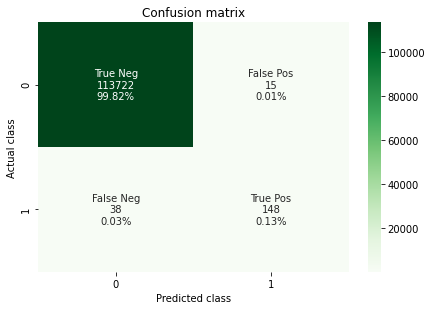

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
estimators_smote_selected = [
                #('Logis', LogisticRegression())#,
                ('XGB', RandomSearch_XGB_smote_best_estimator)#,
                #('Gra_Boost', Gra_best_estimator),
                #('Ada_Boost', Ada_best_estimator),
                #('RandomForest', RFC_best_estimator)                
             ]
             
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()
print(start_time)

ST_RF_test1_smote_CV3_selected3=StackingClassifier(cv=5,
                   estimators=estimators_smote_selected,
                   final_estimator=RandomForestClassifier(),
                   n_jobs=10, passthrough=False, stack_method='auto', verbose=2)
ST_RF_test1_smote_CV3_selected3.fit(X_test1, y_test1)
print("--- %s seconds ---" % (time.time() - start_time))


# Evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
ST_RF_test2_smote_CV3_selected3_report =classification_report(y_test2,  ST_RF_test1_smote_CV3_selected3.predict(X_test2),  output_dict=True)
print(ST_RF_test2_smote_CV3_selected3_report['0']['recall'], ST_RF_test2_smote_CV3_selected3_report['1']['recall'], ST_RF_test2_smote_CV3_selected3_report['macro avg']['recall'])
print(classification_report(y_test2,  ST_RF_test1_smote_CV3_selected3.predict(X_test2)))
print(classification_report(y_test1,  ST_RF_test1_smote_CV3_selected3.predict(X_test1)))
print("--- %s seconds ---" % (time.time() - start_time))

cla_random_ada_logis=classification_report(y_test1,  ST_RF_test1_smote_CV3_selected3.predict(X_test1), output_dict=True)
cla_random_ada_logis['0']['recall'], cla_random_ada_logis['1']['recall'], cla_random_ada_logis['weighted avg']['recall']

# Create Confusion Matrix
optimizedAdaMatrix = confusion_matrix(y_test,ST_RF_test1_smote_CV3_selected3.predict(X_test))

# Create label names
group_names = ['True Neg','False Pos','False Neg','True Pos']

# Extract counts from basic matrix arrays
group_counts = ["{0:0.0f}".format(value) for value in
                optimizedAdaMatrix.flatten()]

# Calculate percentages
group_percentages = ["{0:.2%}".format(value) for value in
                     optimizedAdaMatrix.flatten()/np.sum(optimizedAdaMatrix)]

# Create actual labels by zipping together previous lists
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Create heatmap
sns.heatmap(optimizedAdaMatrix, annot=labels, fmt='', cmap='Greens')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
pass

#### Ada, Random, XGB

1607396998.6969457
--- 772.8982357978821 seconds ---
0.9998593134496342 0.7142857142857143 0.8570725138676742
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.71      0.80        98

    accuracy                           1.00     56962
   macro avg       0.95      0.86      0.90     56962
weighted avg       1.00      1.00      1.00     56962

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56873
           1       1.00      0.93      0.96        88

    accuracy                           1.00     56961
   macro avg       1.00      0.97      0.98     56961
weighted avg       1.00      1.00      1.00     56961

--- 792.0403244495392 seconds ---


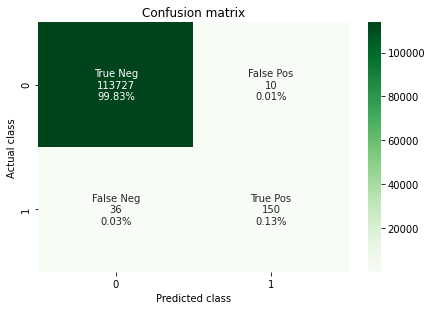

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
estimators_smote_selected = [
                #('Logis', LogisticRegression())#,
                #('XGB', RandomSearch_XGB_smote_best_estimator)#,
                #('Gra_Boost', Gra_best_estimator),
                ('Ada_Boost', Ada_best_estimator),
                ('RandomForest', RFC_best_estimator)                
             ]
             
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()
print(start_time)

ST_RF_test1_smote_CV3_selected3=StackingClassifier(cv=5,
                   estimators=estimators_smote_selected,
                   final_estimator=XGBClassifier(),
                   n_jobs=10, passthrough=False, stack_method='auto', verbose=2)
ST_RF_test1_smote_CV3_selected3.fit(X_test1, y_test1)
print("--- %s seconds ---" % (time.time() - start_time))


# Evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
ST_RF_test2_smote_CV3_selected3_report =classification_report(y_test2,  ST_RF_test1_smote_CV3_selected3.predict(X_test2),  output_dict=True)
print(ST_RF_test2_smote_CV3_selected3_report['0']['recall'], ST_RF_test2_smote_CV3_selected3_report['1']['recall'], ST_RF_test2_smote_CV3_selected3_report['macro avg']['recall'])
print(classification_report(y_test2,  ST_RF_test1_smote_CV3_selected3.predict(X_test2)))
print(classification_report(y_test1,  ST_RF_test1_smote_CV3_selected3.predict(X_test1)))
print("--- %s seconds ---" % (time.time() - start_time))

cla_random_ada_logis=classification_report(y_test1,  ST_RF_test1_smote_CV3_selected3.predict(X_test1), output_dict=True)
cla_random_ada_logis['0']['recall'], cla_random_ada_logis['1']['recall'], cla_random_ada_logis['weighted avg']['recall']

# Create Confusion Matrix
optimizedAdaMatrix = confusion_matrix(y_test,ST_RF_test1_smote_CV3_selected3.predict(X_test))

# Create label names
group_names = ['True Neg','False Pos','False Neg','True Pos']

# Extract counts from basic matrix arrays
group_counts = ["{0:0.0f}".format(value) for value in
                optimizedAdaMatrix.flatten()]

# Calculate percentages
group_percentages = ["{0:.2%}".format(value) for value in
                     optimizedAdaMatrix.flatten()/np.sum(optimizedAdaMatrix)]

# Create actual labels by zipping together previous lists
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Create heatmap
sns.heatmap(optimizedAdaMatrix, annot=labels, fmt='', cmap='Greens')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
pass